In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer, AutoTokenizer, DataCollatorForTokenClassification
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from umap import UMAP
import seaborn as sns
from tqdm import tqdm
import auxiliary as aux
from kingbert import KingBert
import os
from adjustText import adjust_text
from matplotlib import cm, colors
from matplotlib.lines import Line2D
import auxiliary as aux            

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using:", device)         

all_labels = ['B-STREET',
 'B-CITY',
 'I-DATE',
 'B-PASS',
 'I-CITY',
 'B-TIME',
 'B-EMAIL',
 'I-DRIVERLICENSE',
 'I-POSTCODE',
 'I-BOD',
 'B-USERNAME',
 'B-BOD',
 'B-COUNTRY',
 'B-SECADDRESS',
 'B-IDCARD',
 'I-SOCIALNUMBER',
 'I-PASSPORT',
 'B-IP',
 'O',
 'B-TEL',
 'B-SOCIALNUMBER',
 'I-TIME',
 'B-BUILDING',
 'B-PASSPORT',
 'I-TITLE',
 'I-SEX',
 'I-STREET',
 'B-STATE',
 'I-STATE',
 'B-TITLE',
 'B-DATE',
 'B-GEOCOORD',
 'I-IDCARD',
 'I-TEL',
 'B-POSTCODE',
 'B-DRIVERLICENSE',
 'I-GEOCOORD',
 'I-COUNTRY',
 'I-EMAIL',
 'I-PASS',
 'B-SEX',
 'I-USERNAME',
 'I-BUILDING',
 'I-IP',
 'I-SECADDRESS',
 'B-CARDISSUER',
 'I-CARDISSUER']
id2label = {i: l for i, l in enumerate(all_labels)}
label2id = {v: k for k, v in id2label.items()}
target = [l for l in all_labels if l != "O"]


Using: cuda:0


In [93]:
def extract_distilbert_embeddings(model, tokenizer, sentence):
    """Extract raw token embeddings from DistilBERT encoder before classification."""
    model.eval()

    # Tokenize input
    inputs = tokenizer.tokenize(sentence)
    input_ids = torch.tensor([[101] + tokenizer.convert_tokens_to_ids(inputs) + [102]])
    attention_mask = torch.tensor([1 for i in range(len(input_ids))]).unsqueeze(0)

    # Send to same device as model
    device = next(model.parameters()).device
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)

    # Get token-level embeddings from the encoder (before classifier)
    with torch.no_grad():
        outputs = model.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = outputs.last_hidden_state  # shape: (1, seq_len, hidden_dim)

    return hidden_states.squeeze(0).cpu(), tokenizer.convert_ids_to_tokens(input_ids.squeeze(0).tolist())


def extract_albert_embeddings(model, tokenizer, sentence):
    """Extract raw token embeddings from AlBERT encoder before classification."""
    model.eval()

    # Tokenize input
    inputs = tokenizer.tokenize(sentence)
    input_ids = torch.tensor([[101] + tokenizer.convert_tokens_to_ids(inputs) + [102]])
    attention_mask = torch.tensor([1 for i in range(len(input_ids))]).unsqueeze(0)

    # Send to same device as model
    device = next(model.parameters()).device
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)

    # Get token-level embeddings from the encoder (before classifier)
    with torch.no_grad():
        outputs = model.albert(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = outputs.last_hidden_state  # shape: (1, seq_len, hidden_dim)

    return hidden_states.squeeze(0).cpu(), tokenizer.convert_ids_to_tokens(input_ids.squeeze(0).tolist())


def build_palette(labels):
    """
    Return dict: label_id -> hex colour.
    Uses 3 qualitative colormaps concatenated to get 60 different hues.
    """
    cmaps = [cm.get_cmap(name, 20) for name in ("tab20", "tab20b", "tab20c")]
    big   = np.vstack([m(np.arange(20))[:, :3] for m in cmaps])  # (60,3) RGB
    return {i: colors.rgb2hex(big[i]) for i in range(len(labels))}


def visualize_embeddings_2d(
        embeddings,                 # (n_tokens, hidden)
        tokens,                     # list[str]
        token_labels,               # list[int]  same length, BIO id per token
        id2label,                   # dict[int->str]
        method="umap", figsize=(14, 10), dpi=100,
        palette=None,               # dict[label_id]->colour
        show_labels=False,          # text on each dot?
        use_adjusttext=False,       # ignored if show_labels False
        legend=True                 # show full legend?
    ):
    """
    Plot 2-D projection of token embeddings, coloured by BIO label.
    """

    assert len(embeddings) == len(tokens) == len(token_labels)

    # ---------------------------------------------------------------- 1. reduce
    if method == "pca":
        reducer = PCA(n_components=2, random_state=0)
    elif method == "tsne":
        reducer = TSNE(n_components=2, perplexity=5,
                       learning_rate=10, random_state=0)
    else:
        reducer = UMAP(n_neighbors=5, min_dist=.3, random_state=0)

    reduced = reducer.fit_transform(embeddings)
    xs, ys  = reduced[:, 0], reduced[:, 1]

    # ---------------------------------------------------------------- 2. colours
    if palette is None:
        palette = build_palette(id2label)      # 47 distinct hues
    colours = [palette[lbl] for lbl in token_labels]

    # ---------------------------------------------------------------- 3. draw
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    ax.scatter(xs, ys, c=colours, s=30, alpha=.85)

    if show_labels:
        texts = [ax.text(x, y, t, fontsize=9)
                 for x, y, t in zip(xs, ys, tokens)]
        if use_adjusttext:
            from adjustText import adjust_text
            adjust_text(texts, arrowprops=dict(arrowstyle='-',
                                               color='grey', lw=.5))

    ax.set_title(f"Token Embeddings ({method.upper()})")
    ax.axis("off")

    # ---------------------------------------------------------------- 4. legend
    if legend:
        handles = []
        for lbl_id, colour in palette.items():
            if lbl_id in token_labels:             # keep legend short if you down-sampled
                handles.append(Line2D([0], [0], marker='o', ls='',
                                      markerfacecolor=colour,
                                      markeredgecolor='none',
                                      markersize=6,
                                      label=id2label[lbl_id]))
        # put legend outside right edge
        ax.legend(handles=handles, frameon=False,
                  bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)

    plt.tight_layout()
    plt.show()



def visualize_side_by_side(embeddings1, tokens1, labels1, id2label1, palette1,
                           embeddings2, tokens2, labels2, id2label2, palette2,
                           method="tsne", title1="True BIO", title2="Prediction Errors"):
    """
    Visualizes two sets of 2D-projected token embeddings side by side for comparison.

    Parameters:
    -----------
    embeddings1 : np.ndarray of shape (N, D)
        First set of token embeddings (e.g. colored by gold BIO labels).

    tokens1 : list of str
        Tokens corresponding to the first embedding set.

    labels1 : list of int
        Label IDs for each token in the first set.

    id2label1 : dict[int -> str]
        Mapping from label IDs to human-readable class names for the first plot.

    palette1 : dict[int -> str]
        Mapping from label IDs to hex color codes for the first plot.

    method : str, default="tsne"
        Dimensionality reduction method to use: one of {"tsne", "umap", "pca"}.
    """
    reducer = {
        "tsne": TSNE(n_components=2, random_state=0),
        "umap": UMAP(n_neighbors=10, min_dist=0.1, metric='cosine', random_state=0),
        "pca": PCA(n_components=2, random_state=0)
    }[method]

    fig, axs = plt.subplots(1, 2, figsize=(16, 6))
    reduced1 = reducer.fit_transform(embeddings1)
    reduced2 = reducer.fit_transform(embeddings2)

    for ax, reduced, tokens, labels, id2label, palette, title in zip(
        axs,
        [reduced1, reduced2],
        [tokens1, tokens2],
        [labels1, labels2],
        [id2label1, id2label2],
        [palette1, palette2],
        [title1, title2]
    ):
        xs, ys = reduced[:, 0], reduced[:, 1]
        colours = [palette[label] for label in labels]
        ax.scatter(xs, ys, c=colours, s=8, alpha=0.75)

        handles = [
            Line2D([0], [0], marker='o', color='w', label=id2label[i],
                   markerfacecolor=palette[i], markersize=6)
            for i in sorted(set(labels))
        ]
        ax.legend(
            handles=handles,
            loc='center left',
            bbox_to_anchor=(1.05, 0.5),
            borderaxespad=0.,
            fontsize='small',
            frameon=False
        )
        ax.set_title(f"{title} ({method.upper()})")
        ax.axis("off")

    plt.subplots_adjust(right=0.78)
    plt.show()


In [94]:
test_sentence = "My name is Cubo Mancini and my credit card is 5246-4327-8002-6766."

distilbert1 = AutoModelForTokenClassification.from_pretrained('to_share/distilbert1')
tokenizer_distilbert1  = AutoTokenizer.from_pretrained('to_share/distilbert1')

distilbert2 = AutoModelForTokenClassification.from_pretrained('to_share/distilbert2')
tokenizer_distilbert2  = AutoTokenizer.from_pretrained('to_share/distilbert2')

albert1 = AutoModelForTokenClassification.from_pretrained('to_share/albert1')
tokenizer_albert1  = AutoTokenizer.from_pretrained('to_share/albert1')

# Distilbert1

C:\Users\samue\AppData\Local\Temp\ipykernel_9860\2036773760.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmaps = [cm.get_cmap(name, 20) for name in ("tab20", "tab20b", "tab20c")]


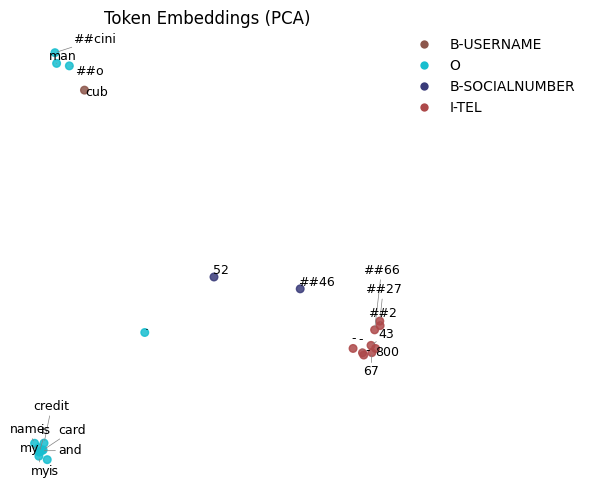

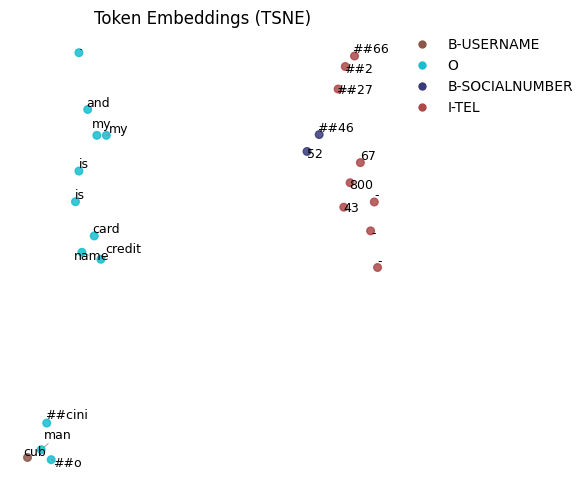

c:\Users\samue\Desktop\nlp-project\cubo_env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\samue\Desktop\nlp-project\cubo_env\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


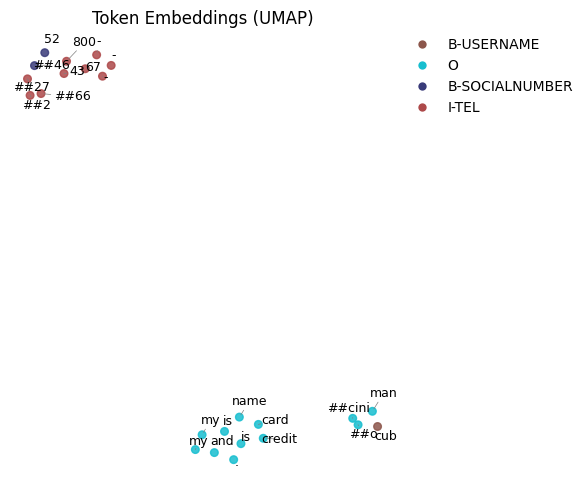

In [120]:
# ---------------------- 1. Extract Token Embeddings (no special tokens) ----------------------
hidden_states, tokens = extract_distilbert_embeddings(distilbert1, tokenizer_distilbert1, test_sentence)

special = {tokenizer_distilbert1.cls_token, tokenizer_distilbert1.sep_token, tokenizer_distilbert1.pad_token}
filtered_tok, filtered_emb = [], []

for i, tok in enumerate(tokens):
    if tok not in special:
        filtered_tok.append(tok)
        filtered_emb.append(hidden_states[i].numpy())  # already on CPU from extract_albert_embeddings

# ---------------------- 2. Predict Labels -----------------------------------------------------
inputs = tokenizer_distilbert1(test_sentence, return_tensors="pt").to(distilbert1.device)

with torch.no_grad():
    logits = distilbert1(**inputs).logits
    preds = logits.argmax(-1).squeeze(0).tolist()

# Align prediction indices with filtered tokens
filtered_lbl = [
    preds[i] for i, tok in enumerate(tokens) if tok not in special
]

# ---------------------- 3. Visualize in 2D ----------------------------------------------------
palette = build_palette(aux.id2label)

for method in ["pca", "tsne", "umap"]:
    visualize_embeddings_2d(
        embeddings     = np.vstack(filtered_emb),
        tokens         = filtered_tok,
        token_labels   = filtered_lbl,
        id2label       = aux.id2label,
        palette        = palette,
        method         = method,
        show_labels    = True,
        use_adjusttext = True,
        legend         = True,
        figsize=(6, 5)
    )


In [96]:
train_json = "data/distilbert_train.json"        
test_json = "data/distilbert_test.json"          
train_dataset    = aux.json_to_Dataset(train_json)
test_dataset    = aux.json_to_Dataset(test_json)

model_name = "to_share/distilbert1"
model      = AutoModelForTokenClassification.from_pretrained(model_name).to(device).eval()
tokenizer  = AutoTokenizer.from_pretrained(model_name)

print("Train dataset len:", len(train_dataset))
print("Test dataset len:", len(test_dataset))

Train dataset len: 18244
Test dataset len: 4811


### Train Dataset

In [97]:
# --- Config ---
MAX_POINTS = 10000
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval()

# --- Collator: pads input_ids/attention_mask, keeps tokens + labels ragged ---
def collate_tok_clf(batch):
    numeric = [
        {k: sample[k] for k in ("input_ids", "attention_mask")}
        for sample in batch
    ]
    padded = tokenizer.pad(
        numeric,
        padding="longest",
        return_tensors="pt"
    )
    padded["tokens"] = [sample["tokens"] for sample in batch]
    padded["labels"] = [sample["labels"] for sample in batch]
    return padded

# --- Dataloader ---
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=False,
    collate_fn=collate_tok_clf
)

# --- Embedding + Prediction Pass ---
train_all_emb, train_all_tok, train_flat_gold, train_flat_pred = [], [], [], []

with torch.no_grad():
    for batch in tqdm(train_loader, desc="Train_Embedding + Train_Prediction"):
        ids = batch["input_ids"].to(DEVICE)
        mask = batch["attention_mask"].to(DEVICE)

        # Embeddings
        h = model.distilbert(input_ids=ids, attention_mask=mask).last_hidden_state
        h = h.cpu().numpy()

        # Predictions
        logits = model(input_ids=ids, attention_mask=mask).logits
        preds = logits.argmax(-1).cpu().tolist()

        # Unpack
        for i, (tokens, labels, pred_row) in enumerate(zip(batch["tokens"], batch["labels"], preds)):
            for j, tok in enumerate(tokens):
                if labels[j] == -100:
                    continue
                train_all_tok.append(tok)
                train_all_emb.append(h[i, j])
                train_flat_gold.append(labels[j])
                train_flat_pred.append(pred_row[j])

Train_Embedding + Train_Prediction: 100%|██████████| 571/571 [01:41<00:00,  5.64it/s]


C:\Users\samue\AppData\Local\Temp\ipykernel_9860\2036773760.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmaps = [cm.get_cmap(name, 20) for name in ("tab20", "tab20b", "tab20c")]


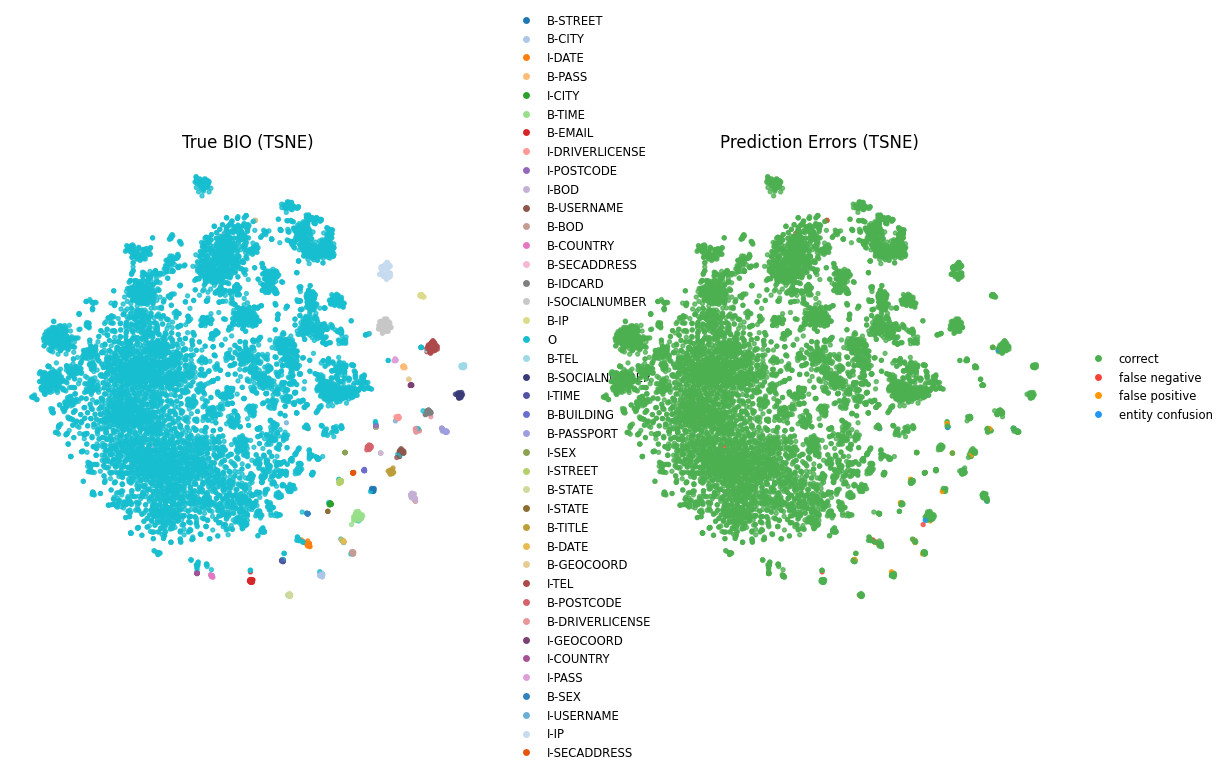

c:\Users\samue\Desktop\nlp-project\cubo_env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\samue\Desktop\nlp-project\cubo_env\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\samue\Desktop\nlp-project\cubo_env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


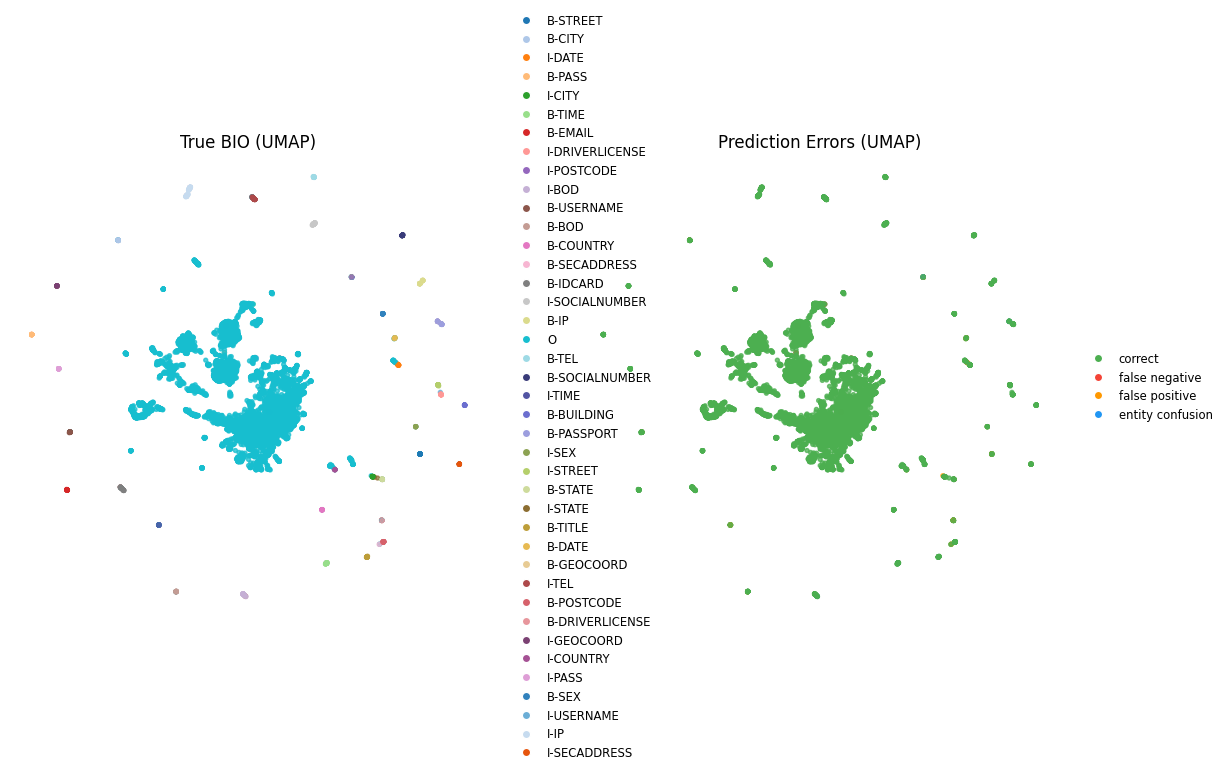

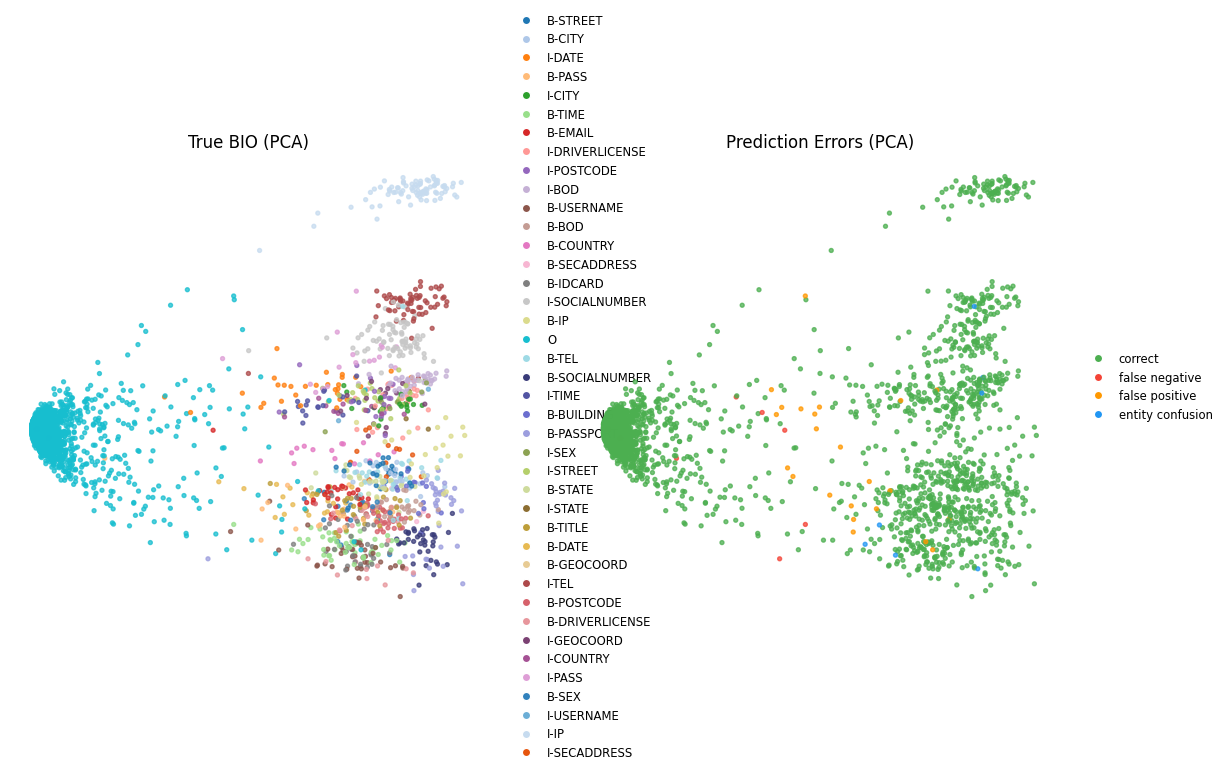

In [98]:
# --- Downsample for TSNE/UMAP ---
if len(train_all_emb) > MAX_POINTS:
    rng = np.random.default_rng(42)
    keep = rng.choice(len(train_all_emb), MAX_POINTS, replace=False)
    train_all_emb = np.array(train_all_emb)[keep]
    train_all_tok = [train_all_tok[i] for i in keep]
    train_flat_gold = [train_flat_gold[i] for i in keep]
    train_flat_pred = [train_flat_pred[i] for i in keep]

# --- Compute error categories ---
label2id = aux.label2id
id2label = aux.id2label
id2label_error = {
    0: "correct",
    1: "false negative",
    2: "false positive",
    3: "entity confusion"
}
custom_palette = {
    0: "#4CAF50",  # green
    1: "#F44336",  # red
    2: "#FF9800",  # orange
    3: "#2196F3"   # blue
}

error_type = []
for g, p in zip(train_flat_gold, train_flat_pred):
    if g == p:
        error_type.append(0)
    elif g != label2id["O"] and p == label2id["O"]:
        error_type.append(1)
    elif g == label2id["O"] and p != label2id["O"]:
        error_type.append(2)
    else:
        error_type.append(3)


# --- Plot all methods side by side ---
palette_bio = build_palette(id2label)
for method in ["tsne", "umap", "pca"]:
    visualize_side_by_side(
        embeddings1=np.vstack(train_all_emb),
        tokens1=train_all_tok,
        labels1=train_flat_gold,
        id2label1=id2label,
        palette1=palette_bio,
        embeddings2=np.vstack(train_all_emb),
        tokens2=train_all_tok,
        labels2=error_type,
        id2label2=id2label_error,
        palette2=custom_palette,
        method=method
    )

In [99]:
# Classification Report: evaluate token-level predictions (excluding -100 already)
print("Token Classification Report Distilbert1 (Train Set)\n")
print(classification_report(
    train_flat_gold,
    train_flat_pred,
    target_names=[id2label[i] for i in sorted(set(train_flat_gold + train_flat_pred))],
    zero_division=0,
    digits=3
))

Token Classification Report Distilbert1 (Train Set)

                 precision    recall  f1-score   support

       B-STREET      0.962     1.000     0.980        25
         B-CITY      0.968     1.000     0.984        30
         I-DATE      0.931     0.900     0.915        30
         B-PASS      1.000     0.950     0.974        20
         I-CITY      0.957     1.000     0.978        22
         B-TIME      0.981     0.962     0.971        53
        B-EMAIL      1.000     0.969     0.984        32
I-DRIVERLICENSE      1.000     1.000     1.000        25
     I-POSTCODE      0.842     1.000     0.914        16
          I-BOD      0.977     1.000     0.988        42
     B-USERNAME      0.971     0.971     0.971        35
          B-BOD      0.960     1.000     0.980        24
      B-COUNTRY      0.941     1.000     0.970        16
   B-SECADDRESS      0.750     1.000     0.857         3
       B-IDCARD      0.972     0.972     0.972        36
 I-SOCIALNUMBER      1.000     1.0

### Test Dataset

In [100]:
# --- Config ---
MAX_POINTS = 5000
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval()

# --- Collator: pads input_ids/attention_mask, keeps tokens + labels ragged ---
def collate_tok_clf(batch):
    numeric = [
        {k: sample[k] for k in ("input_ids", "attention_mask")}
        for sample in batch
    ]
    padded = tokenizer.pad(
        numeric,
        padding="longest",
        return_tensors="pt"
    )
    padded["tokens"] = [sample["tokens"] for sample in batch]
    padded["labels"] = [sample["labels"] for sample in batch]
    return padded

# --- Dataloader ---
test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    collate_fn=collate_tok_clf
)

# --- Embedding + Prediction Pass ---
test_all_emb, test_all_tok, test_flat_gold, test_flat_pred = [], [], [], []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="test_Embedding + test_Prediction"):
        ids = batch["input_ids"].to(DEVICE)
        mask = batch["attention_mask"].to(DEVICE)

        # Embeddings
        h = model.distilbert(input_ids=ids, attention_mask=mask).last_hidden_state
        h = h.cpu().numpy()

        # Predictions
        logits = model(input_ids=ids, attention_mask=mask).logits
        preds = logits.argmax(-1).cpu().tolist()

        # Unpack
        for i, (tokens, labels, pred_row) in enumerate(zip(batch["tokens"], batch["labels"], preds)):
            for j, tok in enumerate(tokens):
                if labels[j] == -100:
                    continue
                test_all_tok.append(tok)
                test_all_emb.append(h[i, j])
                test_flat_gold.append(labels[j])
                test_flat_pred.append(pred_row[j])

test_Embedding + test_Prediction: 100%|██████████| 151/151 [00:25<00:00,  5.89it/s]


C:\Users\samue\AppData\Local\Temp\ipykernel_9860\2036773760.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmaps = [cm.get_cmap(name, 20) for name in ("tab20", "tab20b", "tab20c")]


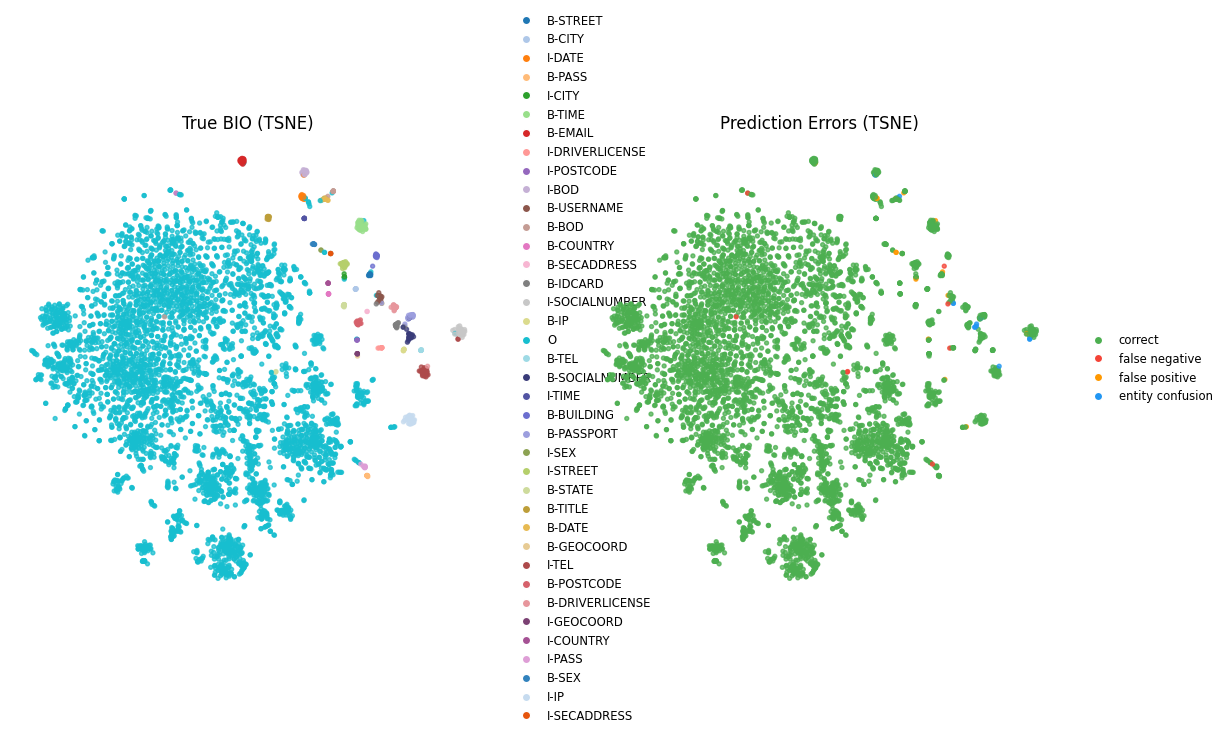

c:\Users\samue\Desktop\nlp-project\cubo_env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\samue\Desktop\nlp-project\cubo_env\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\samue\Desktop\nlp-project\cubo_env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


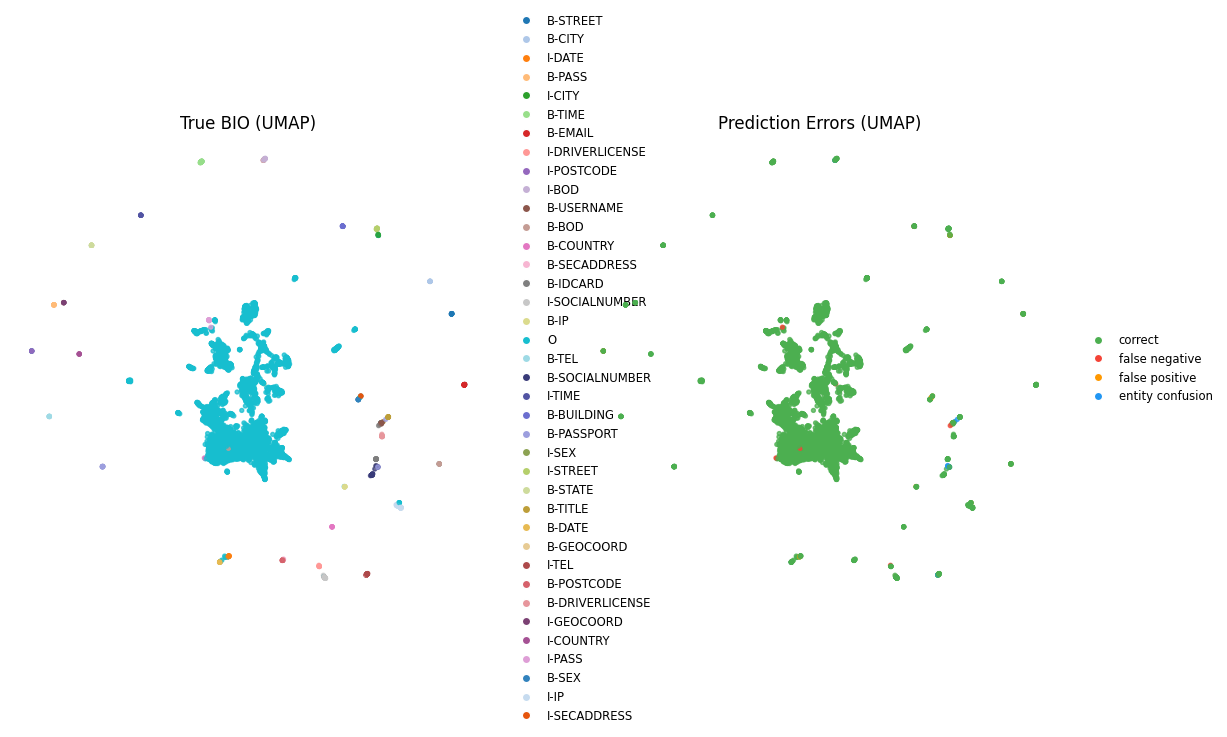

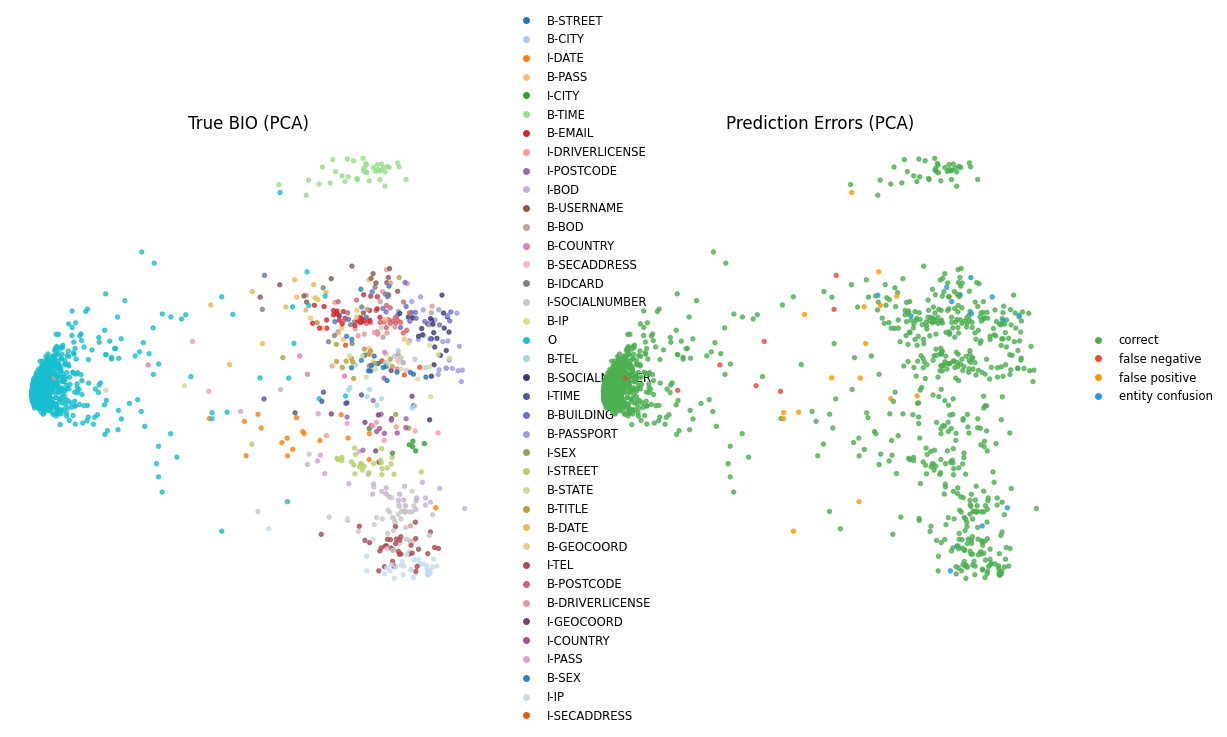

In [101]:
# --- Downsample for TSNE/UMAP ---
if len(test_all_emb) > MAX_POINTS:
    rng = np.random.default_rng(42)
    keep = rng.choice(len(test_all_emb), MAX_POINTS, replace=False)
    test_all_emb = np.array(test_all_emb)[keep]
    test_all_tok = [test_all_tok[i] for i in keep]
    test_flat_gold = [test_flat_gold[i] for i in keep]
    test_flat_pred = [test_flat_pred[i] for i in keep]

# --- Compute error categories ---
label2id = aux.label2id
id2label = aux.id2label
id2label_error = {
    0: "correct",
    1: "false negative",
    2: "false positive",
    3: "entity confusion"
}
custom_palette = {
    0: "#4CAF50",  # green
    1: "#F44336",  # red
    2: "#FF9800",  # orange
    3: "#2196F3"   # blue
}

error_type = []
for g, p in zip(test_flat_gold, test_flat_pred):
    if g == p:
        error_type.append(0)
    elif g != label2id["O"] and p == label2id["O"]:
        error_type.append(1)
    elif g == label2id["O"] and p != label2id["O"]:
        error_type.append(2)
    else:
        error_type.append(3)


# --- Plot all methods side by side ---
palette_bio = build_palette(id2label)
for method in ["tsne", "umap", "pca"]:
    visualize_side_by_side(
        embeddings1=np.vstack(test_all_emb),
        tokens1=test_all_tok,
        labels1=test_flat_gold,
        id2label1=id2label,
        palette1=palette_bio,
        embeddings2=np.vstack(test_all_emb),
        tokens2=test_all_tok,
        labels2=error_type,
        id2label2=id2label_error,
        palette2=custom_palette,
        method=method
    )

In [102]:
# Classification Report: evaluate token-level predictions (excluding -100 already)
print("Token Classification Report (Test Set)\n")
print(classification_report(
    test_flat_gold,
    test_flat_pred,
    target_names=[id2label[i] for i in sorted(set(test_flat_gold + test_flat_pred))],
    zero_division=0,
    digits=3
))

Token Classification Report (Test Set)

                 precision    recall  f1-score   support

       B-STREET      0.933     1.000     0.966        14
         B-CITY      1.000     1.000     1.000         9
         I-DATE      0.895     0.944     0.919        18
         B-PASS      1.000     1.000     1.000        10
         I-CITY      0.875     1.000     0.933         7
         B-TIME      0.975     1.000     0.987        39
        B-EMAIL      0.962     1.000     0.980        25
I-DRIVERLICENSE      1.000     0.875     0.933         8
     I-POSTCODE      0.889     1.000     0.941         8
          I-BOD      0.960     1.000     0.980        24
     B-USERNAME      0.895     1.000     0.944        17
          B-BOD      0.900     0.750     0.818        12
      B-COUNTRY      1.000     0.857     0.923         7
   B-SECADDRESS      1.000     1.000     1.000         2
       B-IDCARD      0.833     0.833     0.833        18
 I-SOCIALNUMBER      0.927     1.000     0.962 

# Distilbert 2

C:\Users\samue\AppData\Local\Temp\ipykernel_9860\2036773760.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmaps = [cm.get_cmap(name, 20) for name in ("tab20", "tab20b", "tab20c")]


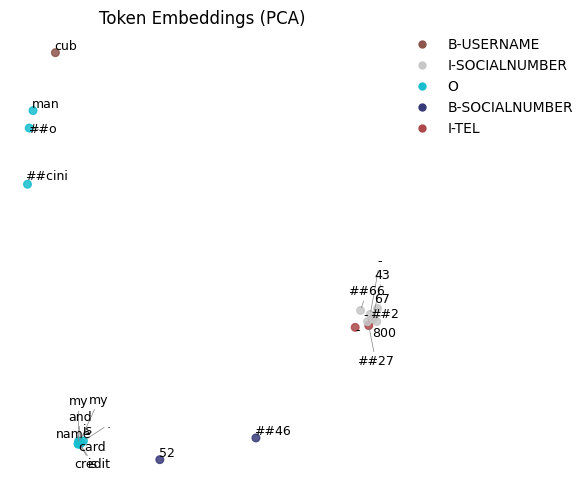

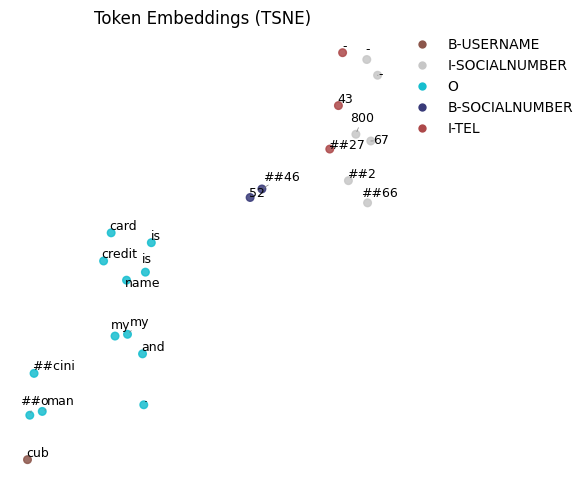

c:\Users\samue\Desktop\nlp-project\cubo_env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\samue\Desktop\nlp-project\cubo_env\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


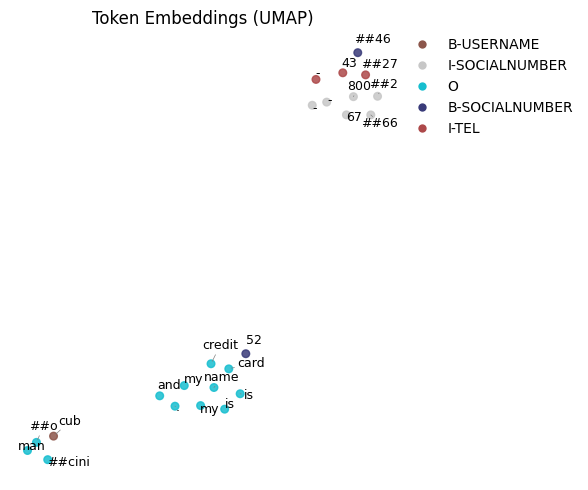

In [121]:
# ---------------------- 1. Extract Token Embeddings (no special tokens) ----------------------
hidden_states, tokens = extract_distilbert_embeddings(distilbert2, tokenizer_distilbert2, test_sentence)

special = {tokenizer_distilbert2.cls_token, tokenizer_distilbert2.sep_token, tokenizer_distilbert2.pad_token}
filtered_tok, filtered_emb = [], []

for i, tok in enumerate(tokens):
    if tok not in special:
        filtered_tok.append(tok)
        filtered_emb.append(hidden_states[i].numpy())  # already on CPU from extract_albert_embeddings

# ---------------------- 2. Predict Labels -----------------------------------------------------
inputs = tokenizer_distilbert2(test_sentence, return_tensors="pt").to(distilbert2.device)

with torch.no_grad():
    logits = distilbert2(**inputs).logits
    preds = logits.argmax(-1).squeeze(0).tolist()

# Align prediction indices with filtered tokens
filtered_lbl = [
    preds[i] for i, tok in enumerate(tokens) if tok not in special
]

# ---------------------- 3. Visualize in 2D ----------------------------------------------------
palette = build_palette(aux.id2label)

for method in ["pca", "tsne", "umap"]:
    visualize_embeddings_2d(
        embeddings     = np.vstack(filtered_emb),
        tokens         = filtered_tok,
        token_labels   = filtered_lbl,
        id2label       = aux.id2label,
        palette        = palette,
        method         = method,
        show_labels    = True,
        use_adjusttext = True,
        legend         = True,
        figsize=(6, 5)
    )


In [104]:
train_json = "data/distilbert_train.json"        
test_json = "data/distilbert_test.json"          
train_dataset    = aux.json_to_Dataset(train_json)
test_dataset    = aux.json_to_Dataset(test_json)

model_name = "to_share/distilbert2"
model      = AutoModelForTokenClassification.from_pretrained(model_name).to(device).eval()
tokenizer  = AutoTokenizer.from_pretrained(model_name)

print("Train dataset len:", len(train_dataset))
print("Test dataset len:", len(test_dataset))

Train dataset len: 18244
Test dataset len: 4811


### Train Dataset

In [105]:
# --- Config ---
MAX_POINTS = 10000
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval()

# --- Collator: pads input_ids/attention_mask, keeps tokens + labels ragged ---
def collate_tok_clf(batch):
    numeric = [
        {k: sample[k] for k in ("input_ids", "attention_mask")}
        for sample in batch
    ]
    padded = tokenizer.pad(
        numeric,
        padding="longest",
        return_tensors="pt"
    )
    padded["tokens"] = [sample["tokens"] for sample in batch]
    padded["labels"] = [sample["labels"] for sample in batch]
    return padded

# --- Dataloader ---
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=False,
    collate_fn=collate_tok_clf
)

# --- Embedding + Prediction Pass ---
train_all_emb, train_all_tok, train_flat_gold, train_flat_pred = [], [], [], []

with torch.no_grad():
    for batch in tqdm(train_loader, desc="Train_Embedding + Train_Prediction"):
        ids = batch["input_ids"].to(DEVICE)
        mask = batch["attention_mask"].to(DEVICE)

        # Embeddings
        h = model.distilbert(input_ids=ids, attention_mask=mask).last_hidden_state
        h = h.cpu().numpy()

        # Predictions
        logits = model(input_ids=ids, attention_mask=mask).logits
        preds = logits.argmax(-1).cpu().tolist()

        # Unpack
        for i, (tokens, labels, pred_row) in enumerate(zip(batch["tokens"], batch["labels"], preds)):
            for j, tok in enumerate(tokens):
                if labels[j] == -100:
                    continue
                train_all_tok.append(tok)
                train_all_emb.append(h[i, j])
                train_flat_gold.append(labels[j])
                train_flat_pred.append(pred_row[j])

Train_Embedding + Train_Prediction: 100%|██████████| 571/571 [01:39<00:00,  5.74it/s]


C:\Users\samue\AppData\Local\Temp\ipykernel_9860\2036773760.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmaps = [cm.get_cmap(name, 20) for name in ("tab20", "tab20b", "tab20c")]


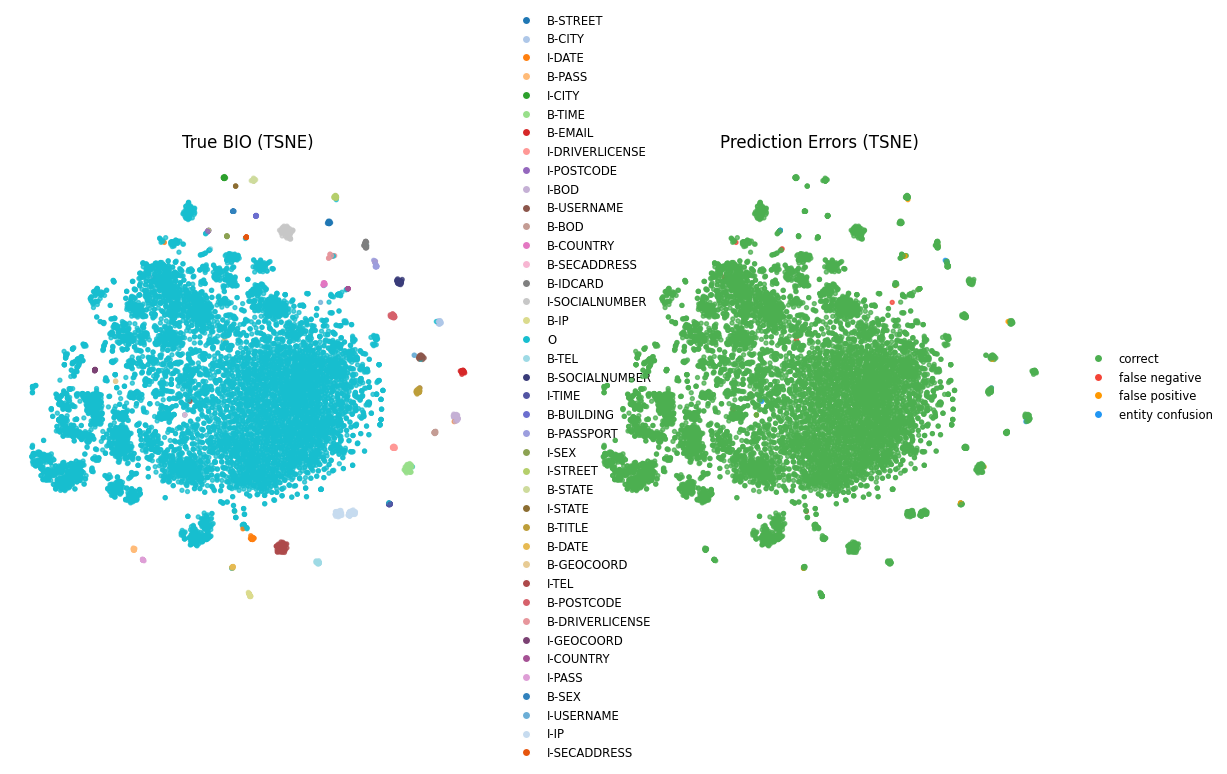

c:\Users\samue\Desktop\nlp-project\cubo_env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\samue\Desktop\nlp-project\cubo_env\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\samue\Desktop\nlp-project\cubo_env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


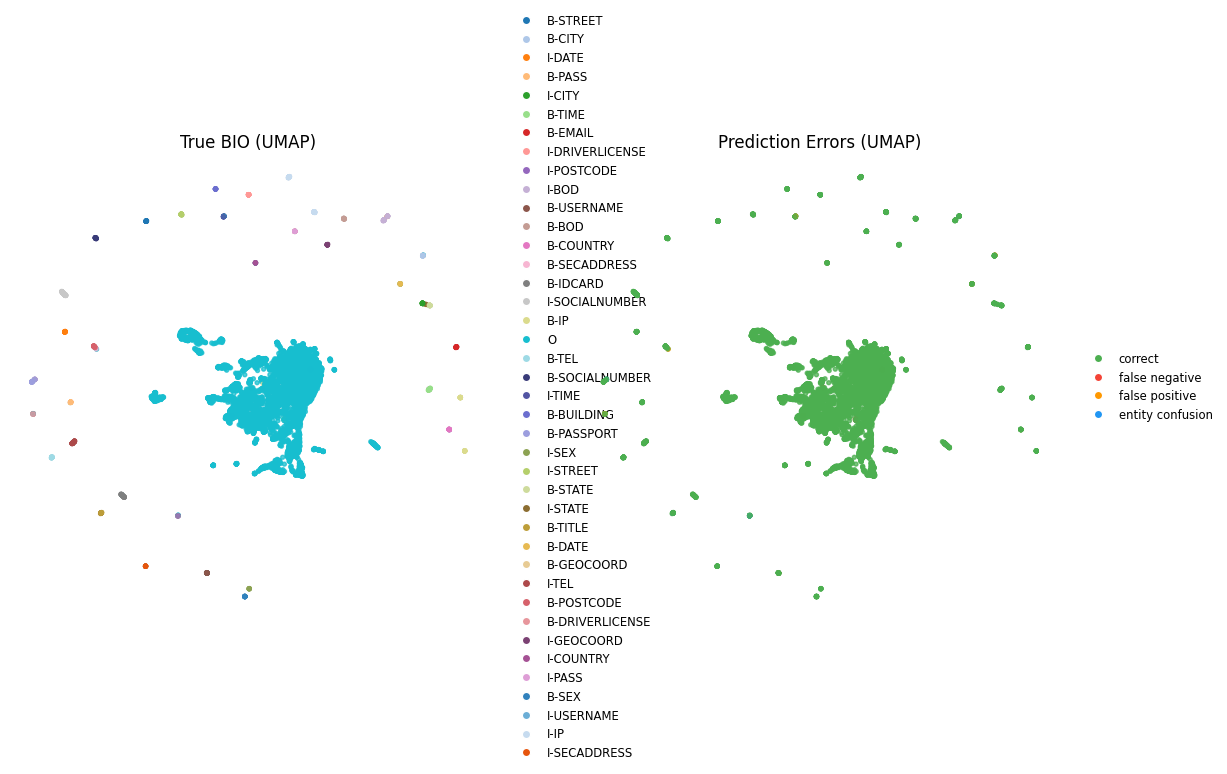

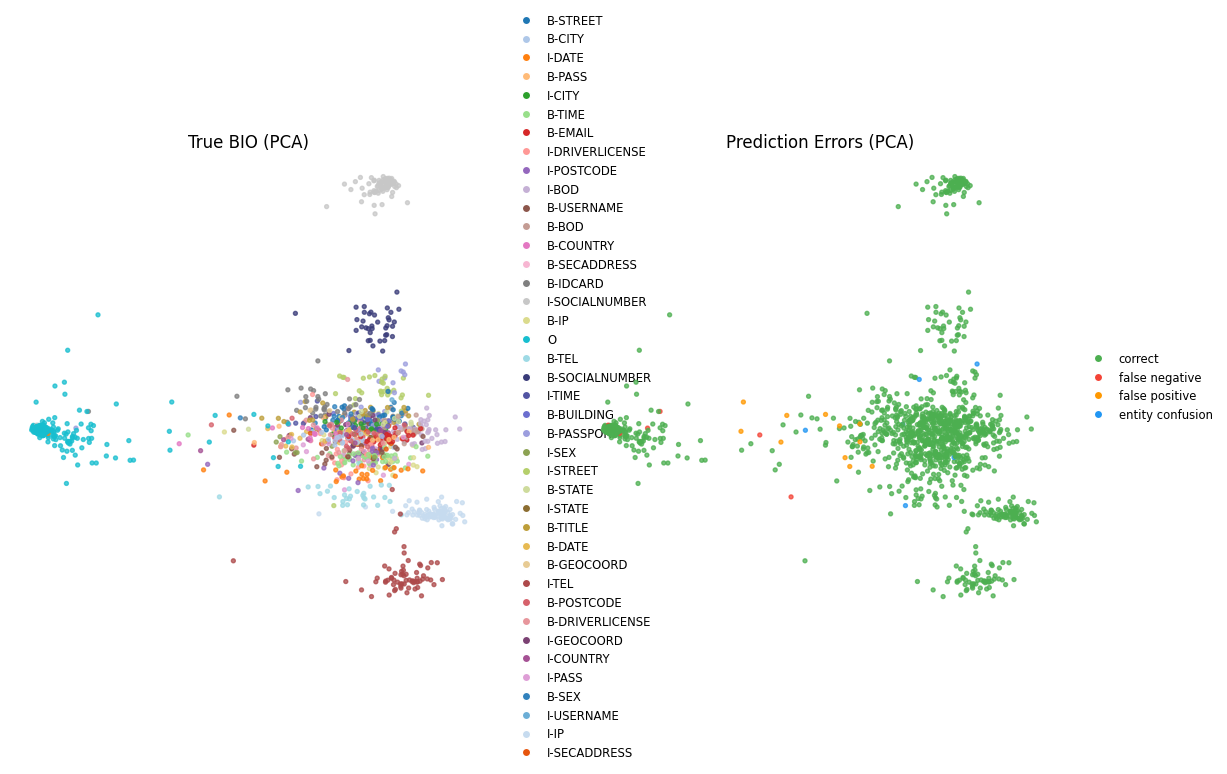

In [106]:
# --- Downsample for TSNE/UMAP ---
if len(train_all_emb) > MAX_POINTS:
    rng = np.random.default_rng(42)
    keep = rng.choice(len(train_all_emb), MAX_POINTS, replace=False)
    train_all_emb = np.array(train_all_emb)[keep]
    train_all_tok = [train_all_tok[i] for i in keep]
    train_flat_gold = [train_flat_gold[i] for i in keep]
    train_flat_pred = [train_flat_pred[i] for i in keep]

# --- Compute error categories ---
label2id = aux.label2id
id2label = aux.id2label
id2label_error = {
    0: "correct",
    1: "false negative",
    2: "false positive",
    3: "entity confusion"
}
custom_palette = {
    0: "#4CAF50",  # green
    1: "#F44336",  # red
    2: "#FF9800",  # orange
    3: "#2196F3"   # blue
}

error_type = []
for g, p in zip(train_flat_gold, train_flat_pred):
    if g == p:
        error_type.append(0)
    elif g != label2id["O"] and p == label2id["O"]:
        error_type.append(1)
    elif g == label2id["O"] and p != label2id["O"]:
        error_type.append(2)
    else:
        error_type.append(3)


# --- Plot all methods side by side ---
palette_bio = build_palette(id2label)
for method in ["tsne", "umap", "pca"]:
    visualize_side_by_side(
        embeddings1=np.vstack(train_all_emb),
        tokens1=train_all_tok,
        labels1=train_flat_gold,
        id2label1=id2label,
        palette1=palette_bio,
        embeddings2=np.vstack(train_all_emb),
        tokens2=train_all_tok,
        labels2=error_type,
        id2label2=id2label_error,
        palette2=custom_palette,
        method=method
    )

In [107]:
# Classification Report: evaluate token-level predictions (excluding -100 already)
print("Token Classification Report Distilbert1 (Train Set)\n")
print(classification_report(
    train_flat_gold,
    train_flat_pred,
    target_names=[id2label[i] for i in sorted(set(train_flat_gold + train_flat_pred))],
    zero_division=0,
    digits=3
))

Token Classification Report Distilbert1 (Train Set)

                 precision    recall  f1-score   support

       B-STREET      1.000     1.000     1.000        25
         B-CITY      0.968     1.000     0.984        30
         I-DATE      1.000     0.933     0.966        30
         B-PASS      1.000     0.950     0.974        20
         I-CITY      1.000     1.000     1.000        22
         B-TIME      0.981     0.981     0.981        53
        B-EMAIL      1.000     1.000     1.000        32
I-DRIVERLICENSE      1.000     1.000     1.000        25
     I-POSTCODE      0.941     1.000     0.970        16
          I-BOD      0.977     1.000     0.988        42
     B-USERNAME      0.971     0.943     0.957        35
          B-BOD      1.000     1.000     1.000        24
      B-COUNTRY      0.941     1.000     0.970        16
   B-SECADDRESS      0.750     1.000     0.857         3
       B-IDCARD      0.946     0.972     0.959        36
 I-SOCIALNUMBER      1.000     0.9

### Test Dataset

In [108]:
# --- Config ---
MAX_POINTS = 5000
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval()

# --- Collator: pads input_ids/attention_mask, keeps tokens + labels ragged ---
def collate_tok_clf(batch):
    numeric = [
        {k: sample[k] for k in ("input_ids", "attention_mask")}
        for sample in batch
    ]
    padded = tokenizer.pad(
        numeric,
        padding="longest",
        return_tensors="pt"
    )
    padded["tokens"] = [sample["tokens"] for sample in batch]
    padded["labels"] = [sample["labels"] for sample in batch]
    return padded

# --- Dataloader ---
test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    collate_fn=collate_tok_clf
)

# --- Embedding + Prediction Pass ---
test_all_emb, test_all_tok, test_flat_gold, test_flat_pred = [], [], [], []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="test_Embedding + test_Prediction"):
        ids = batch["input_ids"].to(DEVICE)
        mask = batch["attention_mask"].to(DEVICE)

        # Embeddings
        h = model.distilbert(input_ids=ids, attention_mask=mask).last_hidden_state
        h = h.cpu().numpy()

        # Predictions
        logits = model(input_ids=ids, attention_mask=mask).logits
        preds = logits.argmax(-1).cpu().tolist()

        # Unpack
        for i, (tokens, labels, pred_row) in enumerate(zip(batch["tokens"], batch["labels"], preds)):
            for j, tok in enumerate(tokens):
                if labels[j] == -100:
                    continue
                test_all_tok.append(tok)
                test_all_emb.append(h[i, j])
                test_flat_gold.append(labels[j])
                test_flat_pred.append(pred_row[j])

test_Embedding + test_Prediction: 100%|██████████| 151/151 [00:25<00:00,  5.86it/s]


C:\Users\samue\AppData\Local\Temp\ipykernel_9860\2036773760.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmaps = [cm.get_cmap(name, 20) for name in ("tab20", "tab20b", "tab20c")]


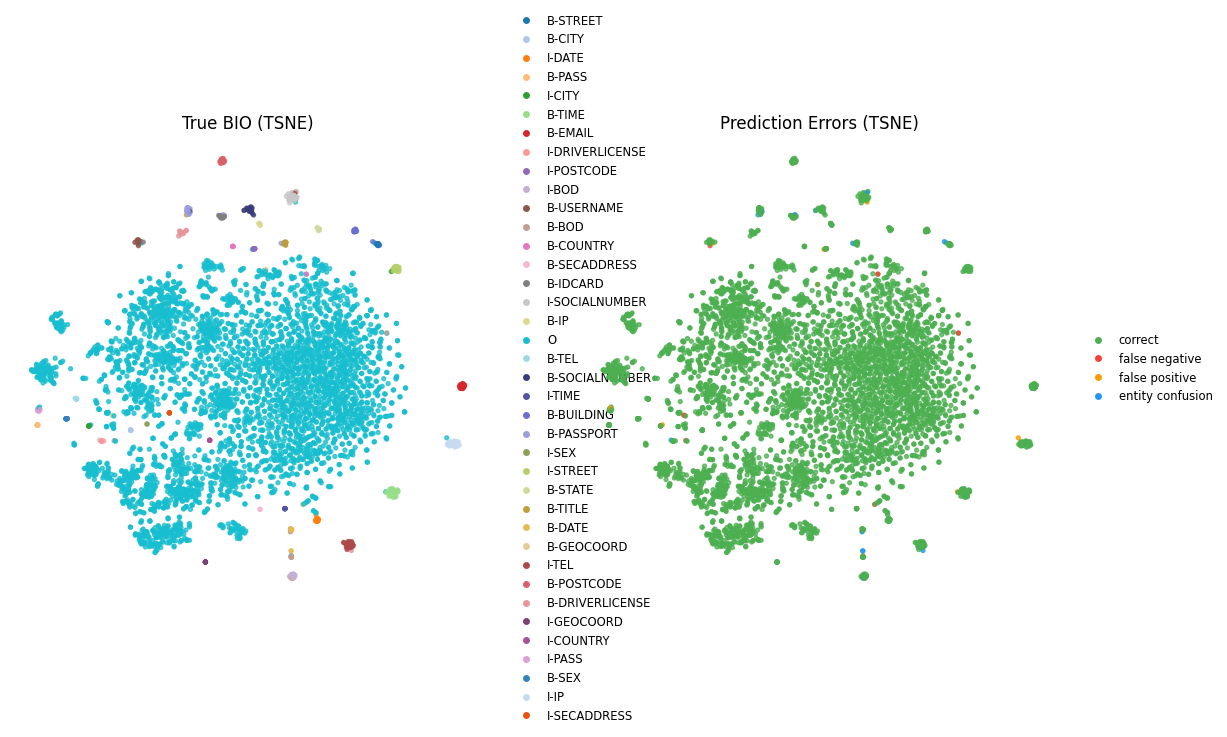

c:\Users\samue\Desktop\nlp-project\cubo_env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\samue\Desktop\nlp-project\cubo_env\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\samue\Desktop\nlp-project\cubo_env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


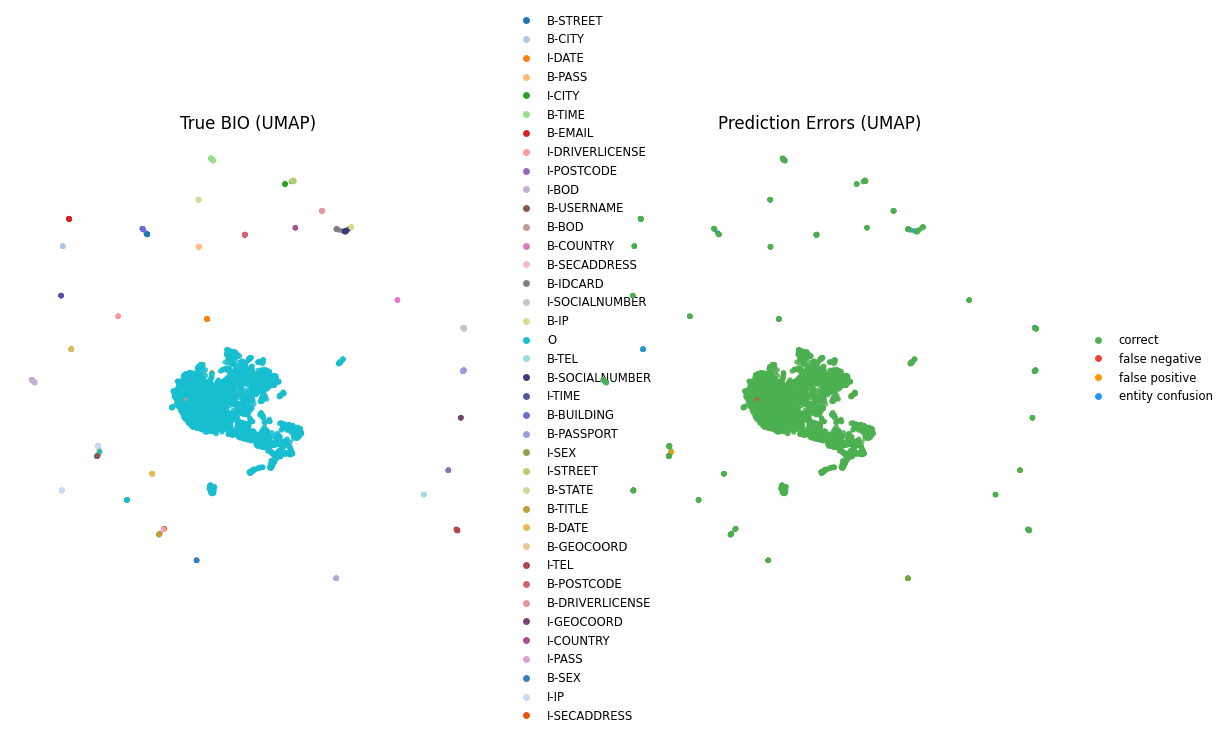

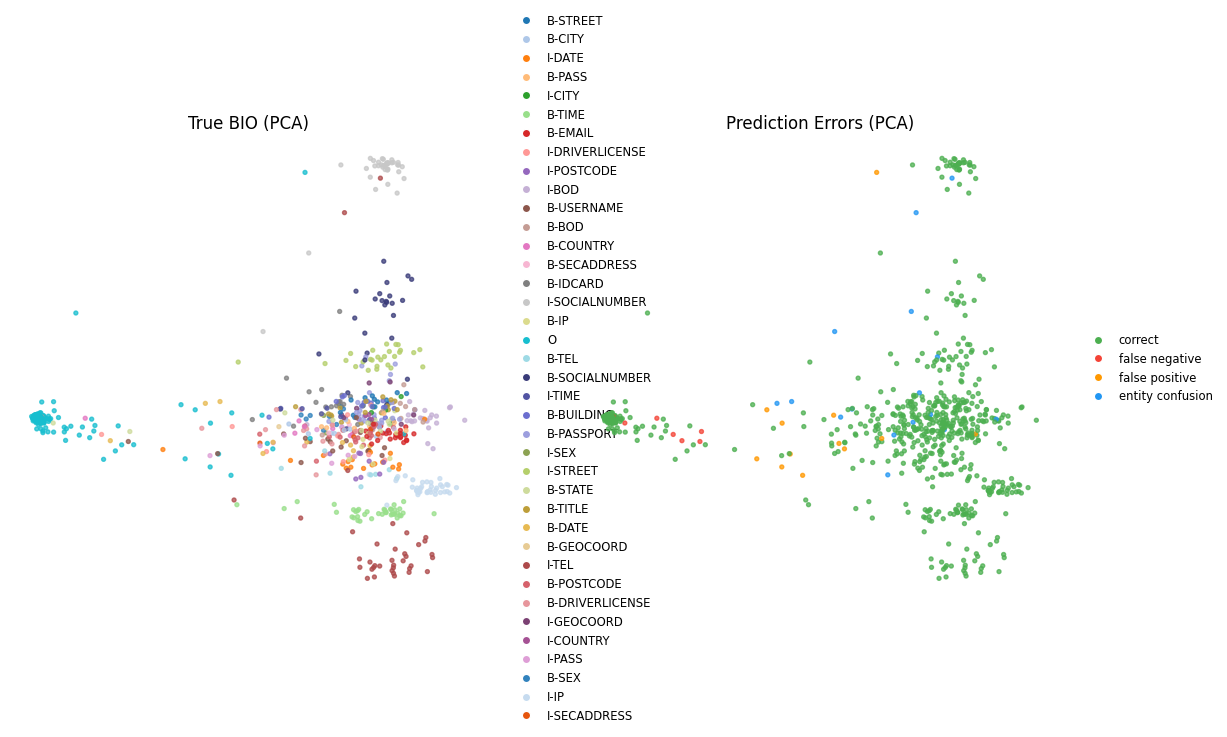

In [109]:
# --- Downsample for TSNE/UMAP ---
if len(test_all_emb) > MAX_POINTS:
    rng = np.random.default_rng(42)
    keep = rng.choice(len(test_all_emb), MAX_POINTS, replace=False)
    test_all_emb = np.array(test_all_emb)[keep]
    test_all_tok = [test_all_tok[i] for i in keep]
    test_flat_gold = [test_flat_gold[i] for i in keep]
    test_flat_pred = [test_flat_pred[i] for i in keep]

# --- Compute error categories ---
label2id = aux.label2id
id2label = aux.id2label
id2label_error = {
    0: "correct",
    1: "false negative",
    2: "false positive",
    3: "entity confusion"
}
custom_palette = {
    0: "#4CAF50",  # green
    1: "#F44336",  # red
    2: "#FF9800",  # orange
    3: "#2196F3"   # blue
}

error_type = []
for g, p in zip(test_flat_gold, test_flat_pred):
    if g == p:
        error_type.append(0)
    elif g != label2id["O"] and p == label2id["O"]:
        error_type.append(1)
    elif g == label2id["O"] and p != label2id["O"]:
        error_type.append(2)
    else:
        error_type.append(3)


# --- Plot all methods side by side ---
palette_bio = build_palette(id2label)
for method in ["tsne", "umap", "pca"]:
    visualize_side_by_side(
        embeddings1=np.vstack(test_all_emb),
        tokens1=test_all_tok,
        labels1=test_flat_gold,
        id2label1=id2label,
        palette1=palette_bio,
        embeddings2=np.vstack(test_all_emb),
        tokens2=test_all_tok,
        labels2=error_type,
        id2label2=id2label_error,
        palette2=custom_palette,
        method=method
    )

In [110]:
# Classification Report: evaluate token-level predictions (excluding -100 already)
print("Token Classification Report (Test Set)\n")
print(classification_report(
    test_flat_gold,
    test_flat_pred,
    target_names=[id2label[i] for i in sorted(set(test_flat_gold + test_flat_pred))],
    zero_division=0,
    digits=3
))

Token Classification Report (Test Set)

                 precision    recall  f1-score   support

       B-STREET      0.933     1.000     0.966        14
         B-CITY      1.000     1.000     1.000         9
         I-DATE      1.000     0.944     0.971        18
         B-PASS      1.000     1.000     1.000        10
         I-CITY      0.875     1.000     0.933         7
         B-TIME      0.975     1.000     0.987        39
        B-EMAIL      0.962     1.000     0.980        25
I-DRIVERLICENSE      0.875     0.875     0.875         8
     I-POSTCODE      0.889     1.000     0.941         8
          I-BOD      0.960     1.000     0.980        24
     B-USERNAME      0.941     0.941     0.941        17
          B-BOD      0.750     0.750     0.750        12
      B-COUNTRY      1.000     0.857     0.923         7
   B-SECADDRESS      1.000     1.000     1.000         2
       B-IDCARD      0.895     0.944     0.919        18
 I-SOCIALNUMBER      0.925     0.974     0.949 

# Albert1

C:\Users\samue\AppData\Local\Temp\ipykernel_9860\2036773760.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmaps = [cm.get_cmap(name, 20) for name in ("tab20", "tab20b", "tab20c")]


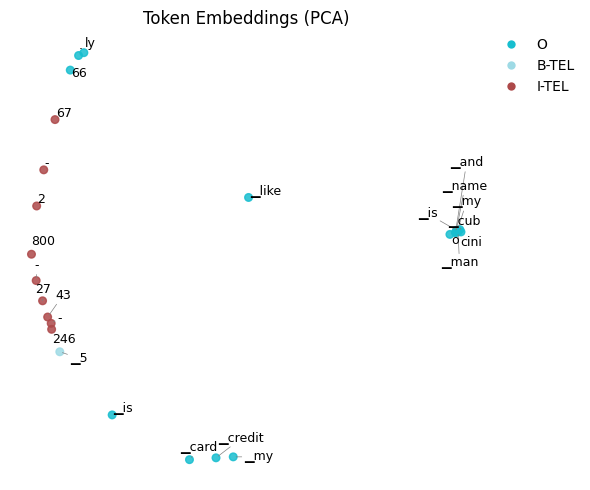

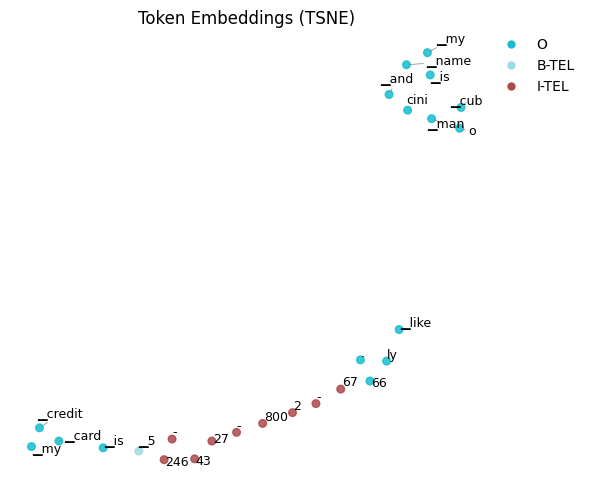

c:\Users\samue\Desktop\nlp-project\cubo_env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\samue\Desktop\nlp-project\cubo_env\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


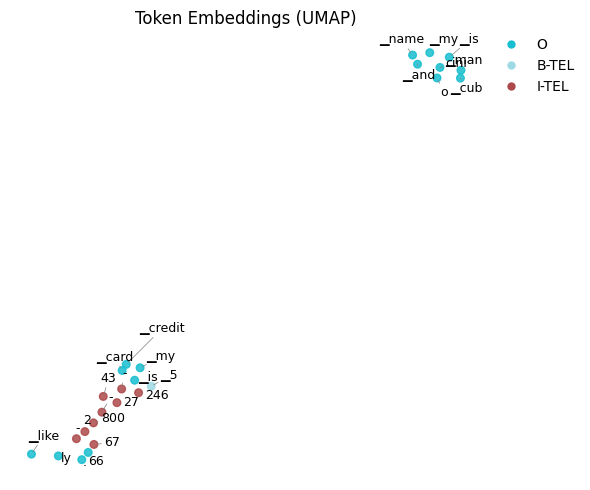

In [118]:
# ---------------------- 1. Extract Token Embeddings (no special tokens) ----------------------
hidden_states, tokens = extract_albert_embeddings(albert1, tokenizer_albert1, test_sentence)

special = {tokenizer_albert1.cls_token, tokenizer_albert1.sep_token, tokenizer_albert1.pad_token}
filtered_tok, filtered_emb = [], []

for i, tok in enumerate(tokens):
    if tok not in special:
        filtered_tok.append(tok)
        filtered_emb.append(hidden_states[i].numpy())  # already on CPU from extract_albert_embeddings

# ---------------------- 2. Predict Labels -----------------------------------------------------
inputs = tokenizer_albert1(test_sentence, return_tensors="pt").to(albert1.device)

with torch.no_grad():
    logits = albert1(**inputs).logits
    preds = logits.argmax(-1).squeeze(0).tolist()

# Align prediction indices with filtered tokens
filtered_lbl = [
    preds[i] for i, tok in enumerate(tokens) if tok not in special
]

# ---------------------- 3. Visualize in 2D ----------------------------------------------------
palette = build_palette(aux.id2label)

for method in ["pca", "tsne", "umap"]:
    visualize_embeddings_2d(
        embeddings     = np.vstack(filtered_emb),
        tokens         = filtered_tok,
        token_labels   = filtered_lbl,
        id2label       = aux.id2label,
        palette        = palette,
        method         = method,
        show_labels    = True,
        use_adjusttext = True,
        legend         = True,
        figsize=(6, 5)
    )


In [86]:
train_json = "data/albert_train.json"        
test_json = "data/albert_test.json"          
train_dataset    = aux.json_to_Dataset(train_json)
test_dataset    = aux.json_to_Dataset(test_json)

model_name = "to_share/albert1"
model      = AutoModelForTokenClassification.from_pretrained(model_name).to(device).eval()
tokenizer  = AutoTokenizer.from_pretrained(model_name)

print("Train dataset len:", len(train_dataset))
print("Test dataset len:", len(test_dataset))

Train dataset len: 18245
Test dataset len: 4811


### Train dataset

In [ ]:
# --- Config ---
MAX_POINTS = 10000
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval()

# --- Collator: pads input_ids/attention_mask, keeps tokens + labels ragged ---
def collate_tok_clf(batch):
    numeric = [
        {k: sample[k] for k in ("input_ids", "attention_mask")}
        for sample in batch
    ]
    padded = tokenizer.pad(
        numeric,
        padding="longest",
        return_tensors="pt"
    )
    padded["tokens"] = [sample["tokens"] for sample in batch]
    padded["labels"] = [sample["labels"] for sample in batch]
    return padded

# --- Dataloader ---
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=False,
    collate_fn=collate_tok_clf
)

# --- Embedding + Prediction Pass ---
train_all_emb, train_all_tok, train_flat_gold, train_flat_pred = [], [], [], []

with torch.no_grad():
    for batch in tqdm(train_loader, desc="Train_Embedding + Train_Prediction"):
        ids = batch["input_ids"].to(DEVICE)
        mask = batch["attention_mask"].to(DEVICE)

        # Embeddings
        h = model.albert(input_ids=ids, attention_mask=mask).last_hidden_state
        h = h.cpu().numpy()

        # Predictions
        logits = model(input_ids=ids, attention_mask=mask).logits
        preds = logits.argmax(-1).cpu().tolist()

        # Unpack
        for i, (tokens, labels, pred_row) in enumerate(zip(batch["tokens"], batch["labels"], preds)):
            for j, tok in enumerate(tokens):
                if labels[j] == -100:
                    continue
                train_all_tok.append(tok)
                train_all_emb.append(h[i, j])
                train_flat_gold.append(labels[j])
                train_flat_pred.append(pred_row[j])

C:\Users\samue\AppData\Local\Temp\ipykernel_9860\1389329550.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmaps = [cm.get_cmap(name, 20) for name in ("tab20", "tab20b", "tab20c")]


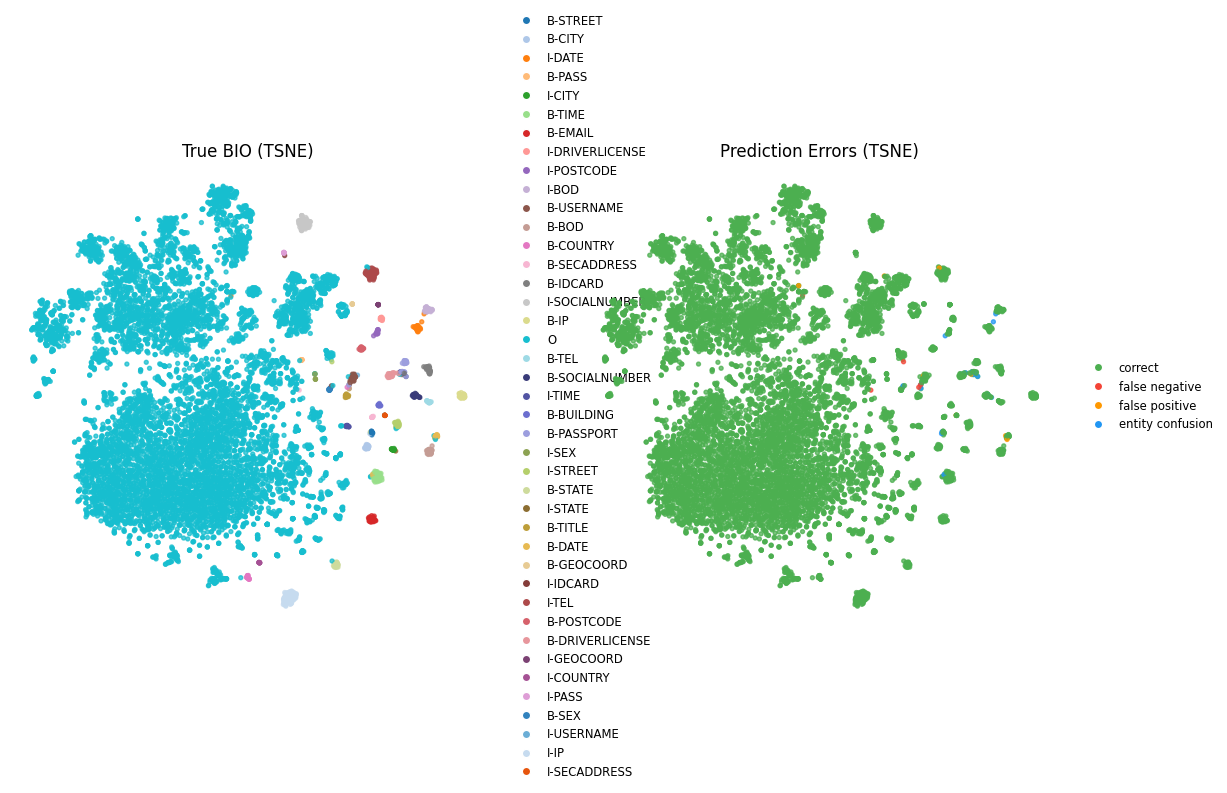

c:\Users\samue\Desktop\nlp-project\cubo_env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\samue\Desktop\nlp-project\cubo_env\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\samue\Desktop\nlp-project\cubo_env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


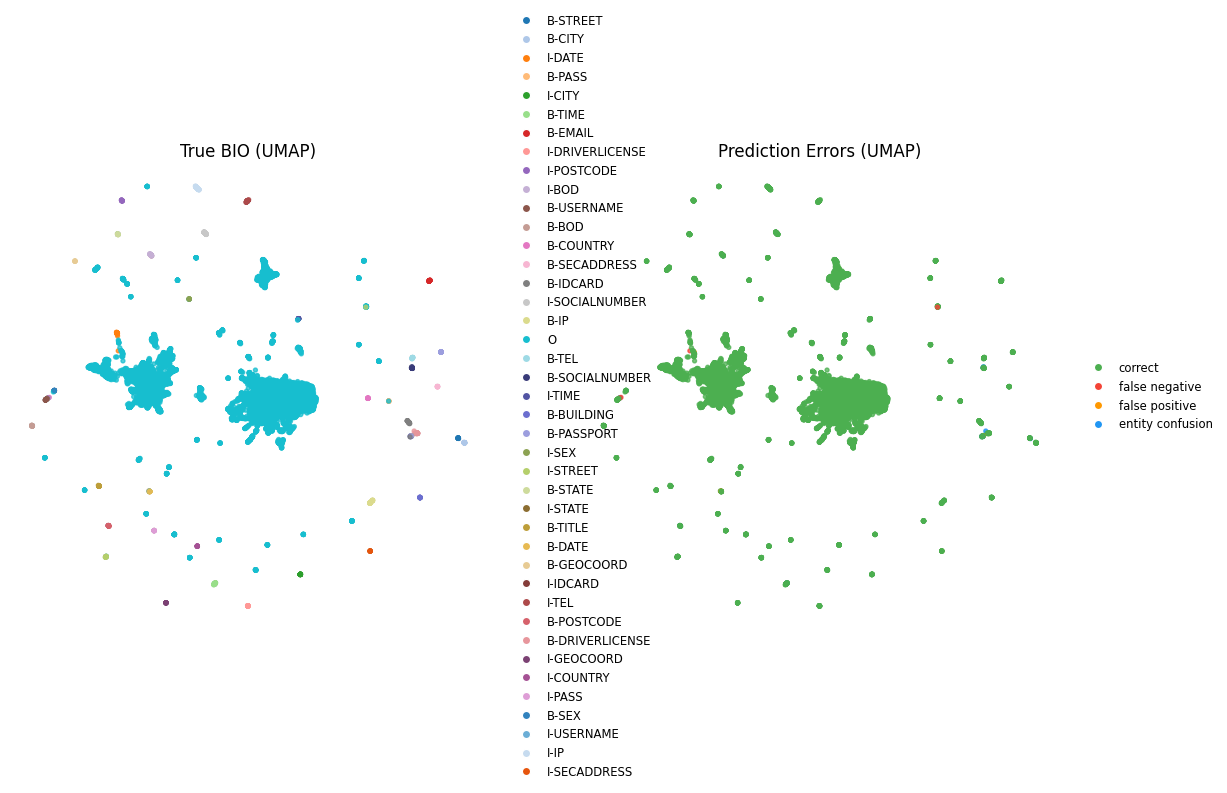

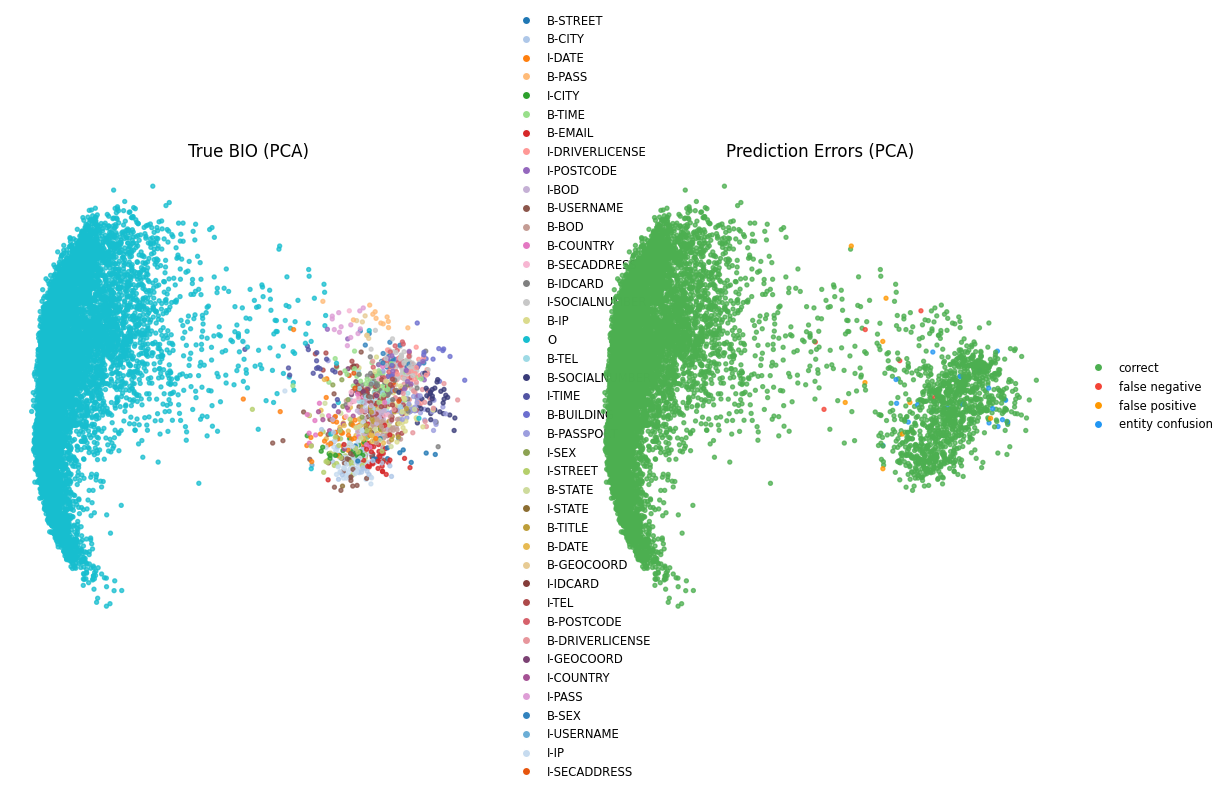

In [ ]:
# --- Downsample for TSNE/UMAP ---
if len(train_all_emb) > MAX_POINTS:
    rng = np.random.default_rng(42)
    keep = rng.choice(len(train_all_emb), MAX_POINTS, replace=False)
    train_all_emb = np.array(train_all_emb)[keep]
    train_all_tok = [train_all_tok[i] for i in keep]
    train_flat_gold = [train_flat_gold[i] for i in keep]
    train_flat_pred = [train_flat_pred[i] for i in keep]

# --- Compute error categories ---
label2id = aux.label2id
id2label = aux.id2label
id2label_error = {
    0: "correct",
    1: "false negative",
    2: "false positive",
    3: "entity confusion"
}
custom_palette = {
    0: "#4CAF50",  # green
    1: "#F44336",  # red
    2: "#FF9800",  # orange
    3: "#2196F3"   # blue
}

error_type = []
for g, p in zip(train_flat_gold, train_flat_pred):
    if g == p:
        error_type.append(0)
    elif g != label2id["O"] and p == label2id["O"]:
        error_type.append(1)
    elif g == label2id["O"] and p != label2id["O"]:
        error_type.append(2)
    else:
        error_type.append(3)


# --- Plot all methods side by side ---
palette_bio = build_palette(id2label)
for method in ["tsne", "umap", "pca"]:
    visualize_side_by_side(
        embeddings1=np.vstack(train_all_emb),
        tokens1=train_all_tok,
        labels1=train_flat_gold,
        id2label1=id2label,
        palette1=palette_bio,
        embeddings2=np.vstack(train_all_emb),
        tokens2=train_all_tok,
        labels2=error_type,
        id2label2=id2label_error,
        palette2=custom_palette,
        method=method
    )

In [ ]:
# Classification Report: evaluate token-level predictions (excluding -100 already)
print("Token Classification Report (Train Set)\n")
print(classification_report(
    train_flat_gold,
    train_flat_pred,
    target_names=[id2label[i] for i in sorted(set(train_flat_gold + train_flat_pred))],
    zero_division=0,
    digits=3
))

Token Classification Report (Train Set)

                 precision    recall  f1-score   support

       B-STREET      0.900     1.000     0.947        18
         B-CITY      1.000     0.969     0.984        32
         I-DATE      1.000     0.919     0.958        37
         B-PASS      0.923     1.000     0.960        12
         I-CITY      1.000     1.000     1.000        22
         B-TIME      0.982     1.000     0.991        56
        B-EMAIL      1.000     1.000     1.000        41
I-DRIVERLICENSE      1.000     1.000     1.000        23
     I-POSTCODE      1.000     0.957     0.978        23
          I-BOD      0.953     1.000     0.976        41
     B-USERNAME      0.927     0.950     0.938        40
          B-BOD      1.000     0.974     0.987        39
      B-COUNTRY      1.000     0.944     0.971        18
   B-SECADDRESS      1.000     0.929     0.963        14
       B-IDCARD      0.952     0.909     0.930        44
 I-SOCIALNUMBER      0.987     1.000     0.993

### Test Dataset

In [87]:
# --- Config ---
MAX_POINTS = 5000
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval()

# --- Collator: pads input_ids/attention_mask, keeps tokens + labels ragged ---
def collate_tok_clf(batch):
    numeric = [
        {k: sample[k] for k in ("input_ids", "attention_mask")}
        for sample in batch
    ]
    padded = tokenizer.pad(
        numeric,
        padding="longest",
        return_tensors="pt"
    )
    padded["tokens"] = [sample["tokens"] for sample in batch]
    padded["labels"] = [sample["labels"] for sample in batch]
    return padded

# --- Dataloader ---
test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    collate_fn=collate_tok_clf
)

# --- Embedding + Prediction Pass ---
test_all_emb, test_all_tok, test_flat_gold, test_flat_pred = [], [], [], []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="test_Embedding + test_Prediction"):
        ids = batch["input_ids"].to(DEVICE)
        mask = batch["attention_mask"].to(DEVICE)

        # Embeddings
        h = model.albert(input_ids=ids, attention_mask=mask).last_hidden_state
        h = h.cpu().numpy()

        # Predictions
        logits = model(input_ids=ids, attention_mask=mask).logits
        preds = logits.argmax(-1).cpu().tolist()

        # Unpack
        for i, (tokens, labels, pred_row) in enumerate(zip(batch["tokens"], batch["labels"], preds)):
            for j, tok in enumerate(tokens):
                if labels[j] == -100:
                    continue
                test_all_tok.append(tok)
                test_all_emb.append(h[i, j])
                test_flat_gold.append(labels[j])
                test_flat_pred.append(pred_row[j])

test_Embedding + test_Prediction: 100%|██████████| 151/151 [01:26<00:00,  1.75it/s]


C:\Users\samue\AppData\Local\Temp\ipykernel_9860\1389329550.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmaps = [cm.get_cmap(name, 20) for name in ("tab20", "tab20b", "tab20c")]


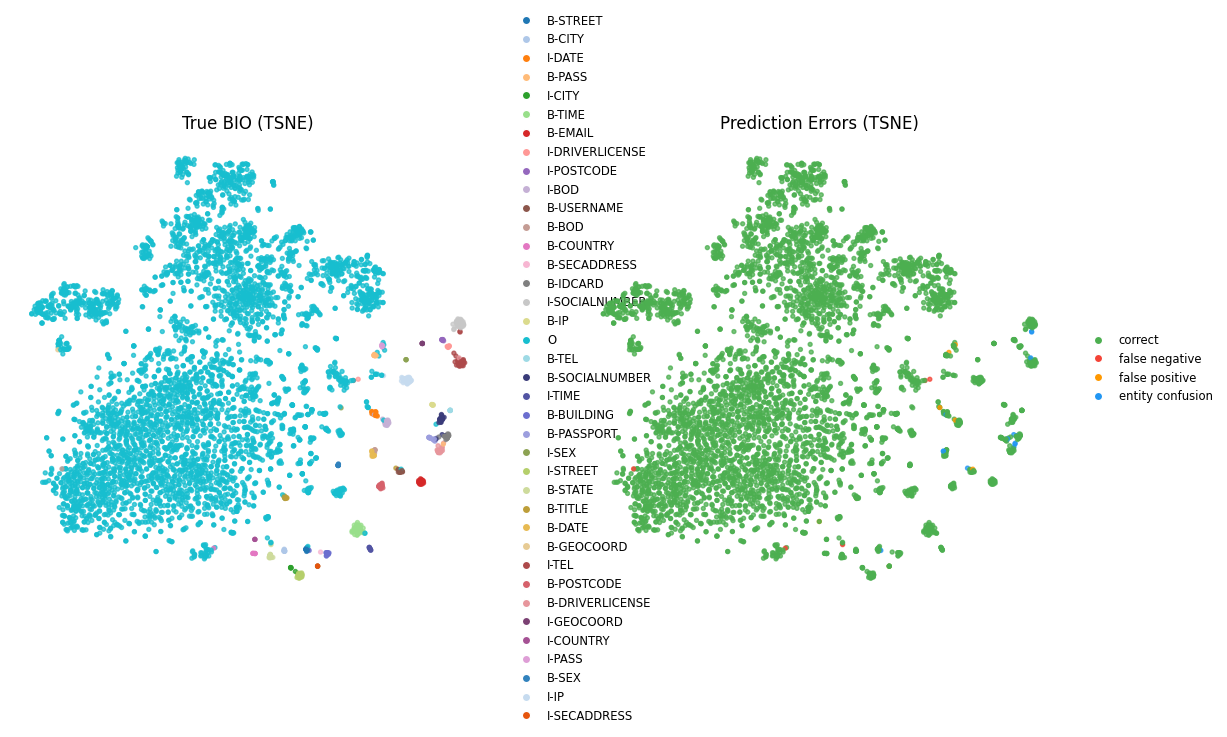

c:\Users\samue\Desktop\nlp-project\cubo_env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\samue\Desktop\nlp-project\cubo_env\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\samue\Desktop\nlp-project\cubo_env\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


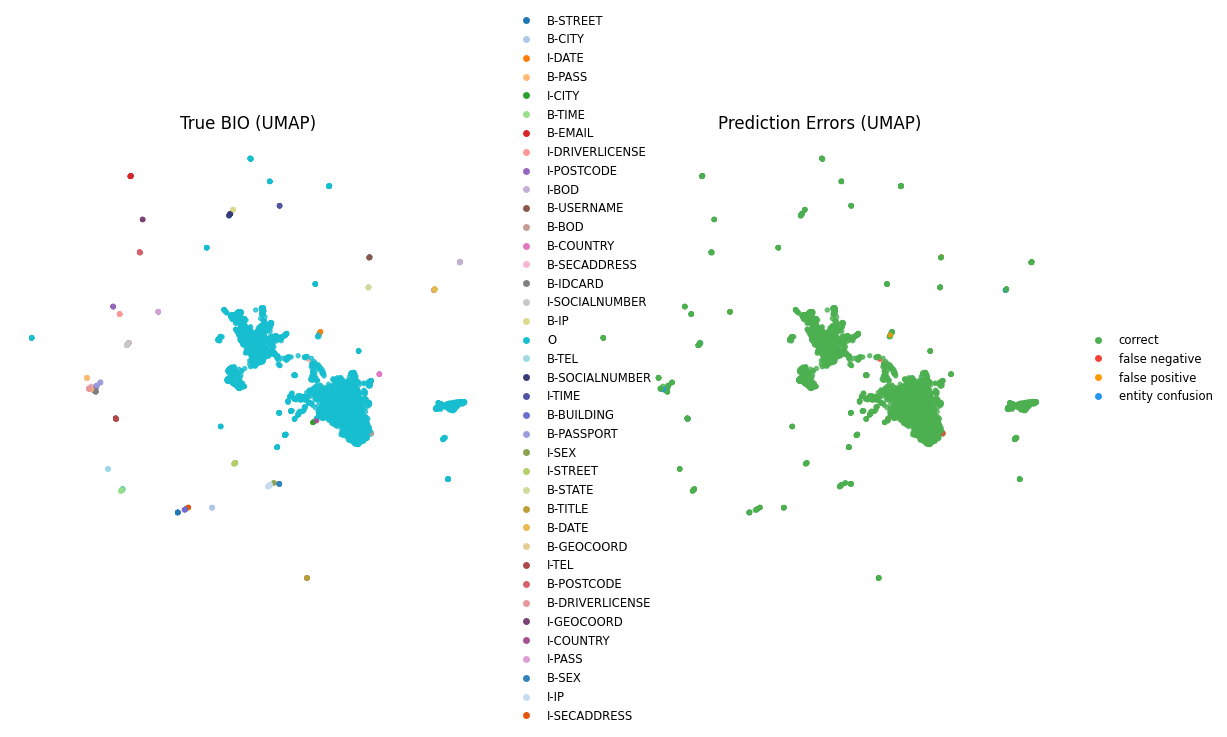

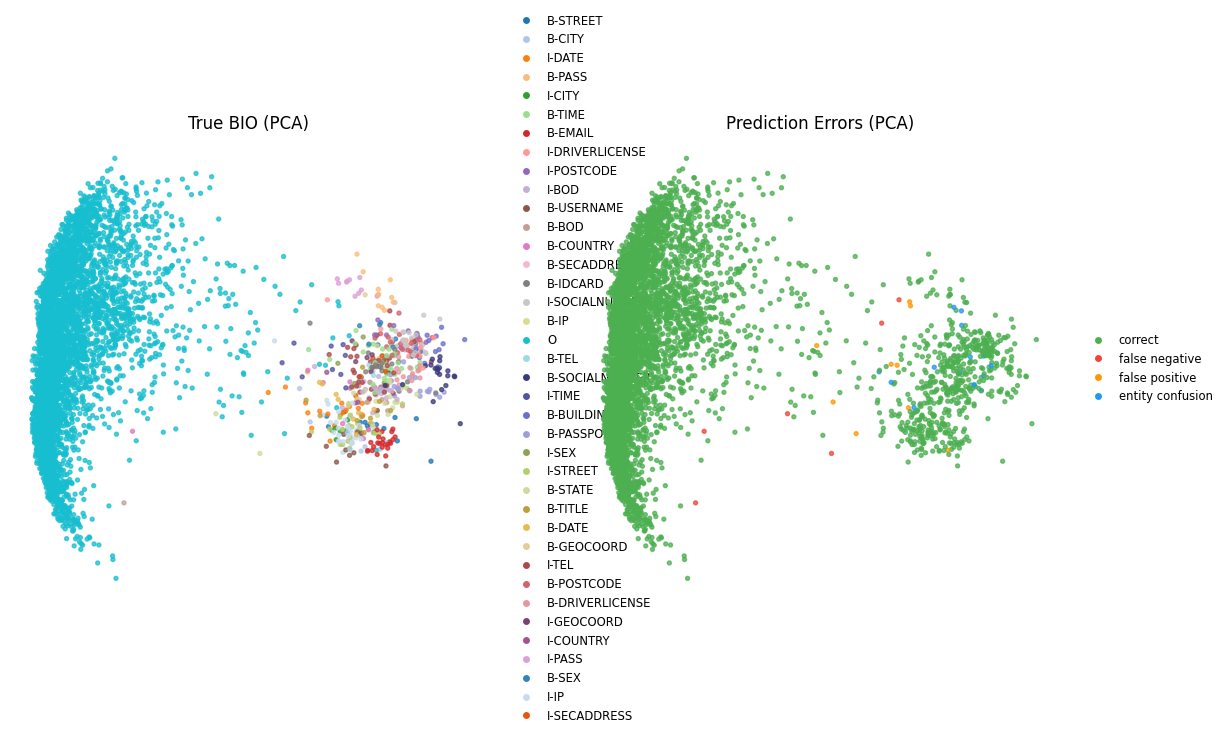

In [88]:
# --- Downsample for TSNE/UMAP ---
if len(test_all_emb) > MAX_POINTS:
    rng = np.random.default_rng(42)
    keep = rng.choice(len(test_all_emb), MAX_POINTS, replace=False)
    test_all_emb = np.array(test_all_emb)[keep]
    test_all_tok = [test_all_tok[i] for i in keep]
    test_flat_gold = [test_flat_gold[i] for i in keep]
    test_flat_pred = [test_flat_pred[i] for i in keep]

# --- Compute error categories ---
label2id = aux.label2id
id2label = aux.id2label
id2label_error = {
    0: "correct",
    1: "false negative",
    2: "false positive",
    3: "entity confusion"
}
custom_palette = {
    0: "#4CAF50",  # green
    1: "#F44336",  # red
    2: "#FF9800",  # orange
    3: "#2196F3"   # blue
}

error_type = []
for g, p in zip(test_flat_gold, test_flat_pred):
    if g == p:
        error_type.append(0)
    elif g != label2id["O"] and p == label2id["O"]:
        error_type.append(1)
    elif g == label2id["O"] and p != label2id["O"]:
        error_type.append(2)
    else:
        error_type.append(3)


# --- Plot all methods side by side ---
palette_bio = build_palette(id2label)
for method in ["tsne", "umap", "pca"]:
    visualize_side_by_side(
        embeddings1=np.vstack(test_all_emb),
        tokens1=test_all_tok,
        labels1=test_flat_gold,
        id2label1=id2label,
        palette1=palette_bio,
        embeddings2=np.vstack(test_all_emb),
        tokens2=test_all_tok,
        labels2=error_type,
        id2label2=id2label_error,
        palette2=custom_palette,
        method=method
    )

In [89]:
# Classification Report: evaluate token-level predictions (excluding -100 already)
print("Token Classification Report (Test Set)\n")
print(classification_report(
    test_flat_gold,
    test_flat_pred,
    target_names=[id2label[i] for i in sorted(set(test_flat_gold + test_flat_pred))],
    zero_division=0,
    digits=3
))

Token Classification Report (Test Set)

                 precision    recall  f1-score   support

       B-STREET      0.929     1.000     0.963        13
         B-CITY      1.000     1.000     1.000        11
         I-DATE      0.900     1.000     0.947        18
         B-PASS      1.000     0.909     0.952        11
         I-CITY      1.000     1.000     1.000         6
         B-TIME      1.000     1.000     1.000        40
        B-EMAIL      0.960     1.000     0.980        24
I-DRIVERLICENSE      1.000     0.909     0.952        11
     I-POSTCODE      1.000     1.000     1.000         9
          I-BOD      0.958     0.958     0.958        24
     B-USERNAME      0.867     1.000     0.929        13
          B-BOD      0.778     0.875     0.824         8
      B-COUNTRY      1.000     0.875     0.933         8
   B-SECADDRESS      1.000     1.000     1.000         1
       B-IDCARD      0.773     0.944     0.850        18
 I-SOCIALNUMBER      0.949     1.000     0.974 